<a href="https://colab.research.google.com/github/tinahuang222/NucleiSegmentation/blob/master/PREPROCESSING/ColorConvolve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
%matplotlib inline

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle

!pip3 install histomicstk
import histomicstk as htk
#specific versions required for downloaded code segments
#!pip3 install -q scipy==1.2.0
#!pip3 install -q imgaug==0.2.6


################################################################################
# Read Data from google drive
################################################################################
from google.colab import drive #for loading gdrive data
drive.mount('/content/gdrive')

###                     MAIN DIRECTORY NAMES
gdir = '/content/gdrive/My Drive/'
main_directory = gdir

#
#directory of top level of user data
#
feature_folder = os.path.join(gdir,'FEATURE_EXTRACTION')
original_image_folder = os.path.join(feature_folder,'tiles_rois','original')

tiles_dir = os.path.join(feature_folder,'tiles_rois','normalized')
tile_melanomas_dir = os.path.join(gdir,feature_folder,'tile_melanomas_examples')
tile_label_dir = os.path.join(gdir,feature_folder,'tiles_rois')
mask_dir = os.path.join(gdir,'masks')

preprocess_dir = os.path.join(gdir,'TILE_PREPROCESSING')
original_output_dir = os.path.join(gdir,'TILE_PREPROCESSING','ORIGINAL_TO_HE')




#pickle file used to store full image sets, which take more than a minute to run
pickle_file = os.path.join(preprocess_dir,'PICKLE_FILE.pck')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Now at image #  0
Now at image #  100
Now at image #  200
Now at image #  300
Now at image #  400
Now at image #  500
Now at image #  600
Now at image #  700
Now at image #  800
Now at image #  900


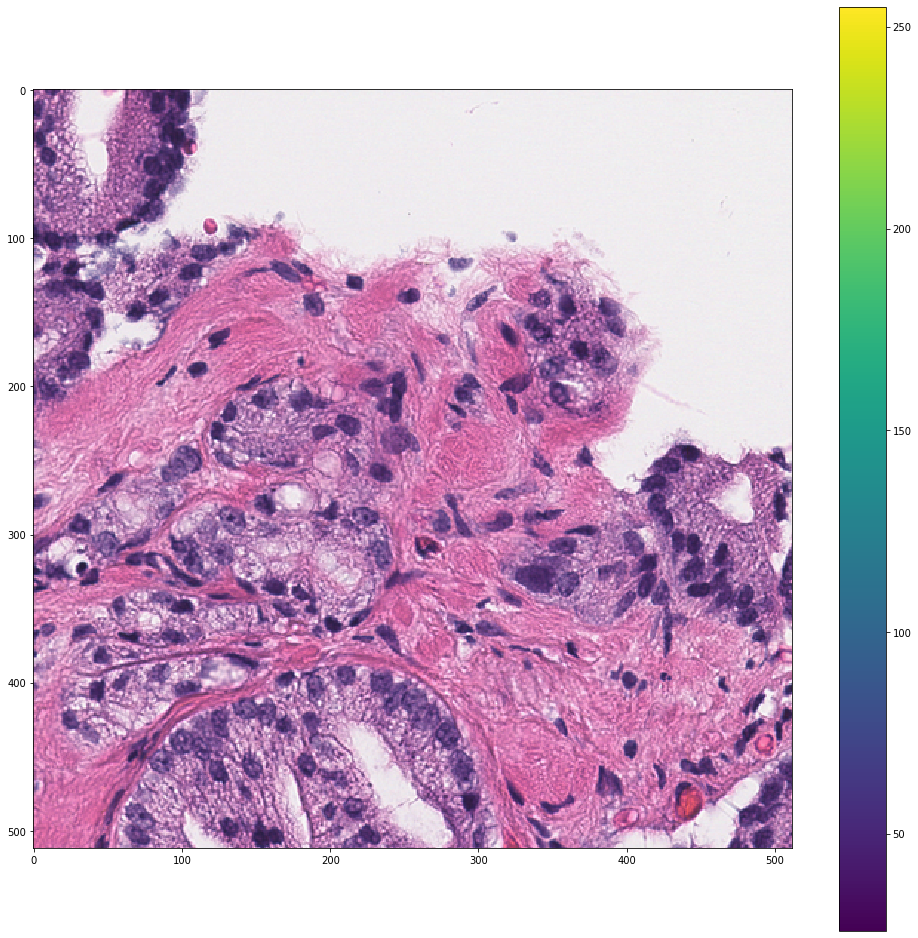

In [34]:
'''
Get image files and load them into memory
'''


#get listing of image files in directory
image_files = os.listdir(original_image_folder)

image_names =[]
#store filenames without extension for output purposes later
for filename in image_files:
    root_ext = os.path.splitext(filename) #will return two parts, name and ext
    image_names.append(root_ext[0])


#open the images
image_data = {}
for fcounter,filename in enumerate(image_files):
    full_filename = os.path.join(original_image_folder,filename)
    #root_ext = os.path.splitext(filename)
    #tile_file = root_ext[0] + '.png'
    #    tile_roi_file = os.path.join(tiles_dir, tile_file)

    if ((fcounter % 100) == 0):
        print('Now at image # ', fcounter)
    
    image_data[fcounter] = Image.open(full_filename)
    

#review sample image
plt.figure(figsize=(17, 17))
plt.imshow(image_data[5])
plt.colorbar()
plt.show()

In [42]:
'''
Save intermediate data to a pickle file. This should save some recomputing time
'''

print('pickle file is ', pickle_file)
with open(pickle_file, 'wb') as f:
    pickle.dump(image_data, f)

print('Saved full image set to pickle file')

pickle file is  /content/gdrive/My Drive/TILE_PREPROCESSING/PICKLE_FILE.pck


In [47]:
'''
Perform histomicsTK prep
'''

#defaults for HE staining from HTK site
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

deconvolved_image_h={}
deconvolved_image_e={}
for ii,fcounter in enumerate(image_data):

    if ((fcounter % 100) == 0):
        print('Now Deconvolving image # ', fcounter)
    imInput = np.array(image_data[0]) #convert to NP array format first
    # perform standard color deconvolution
    imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

    #store this output set in H and E dictionaries
    deconvolved_image_h[fcounter] = imDeconvolved.Stains[:,:,0]
    deconvolved_image_e[fcounter] = imDeconvolved.Stains[:,:,1]

print('shape of imDeconvolved is ', np.shape(imDeconvolved))


stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}
Now Deconvolving image #  0
Now Deconvolving image #  100
Now Deconvolving image #  200
Now Deconvolving image #  300
Now Deconvolving image #  400
Now Deconvolving image #  500
Now Deconvolving image #  600
Now Deconvolving image #  700
Now Deconvolving image #  800
Now Deconvolving image #  900
shape of imDeconvolved is  (3,)


In [0]:
for ii in range(0,len(deconvolved_image_h)):

    current_image_name = image_names[ii]

    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, 0],cmap = 'gray')
    htitle = 'Hematoxylin_' + current_image_name + '_File#_'+ str(ii)
    hfile = htitle + '.png'
    hfile = os.path.join(original_output_dir,hfile);
    plt.colorbar()
    plt.title(htitle)
    plt.savefig(hfile, format='png',dpi=300, bbox_inches='tight')

    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, 1],cmap = 'gray')
    etitle = 'Eosin_' + current_image_name + '_File#_'+ str(ii)
    efile = etitle + '.png'
    efile = os.path.join(original_output_dir,efile);
    plt.colorbar()
    plt.title(etitle)
    plt.savefig(efile, format='png',dpi=300, bbox_inches='tight')


    if ((ii % 100) == 0):
        print('Now Writing Deconvolved Image to GDRIVE:# ', ii)


    plt.close('all')


Now Writing Deconvolved Image to GDRIVE:#  0
Now Writing Deconvolved Image to GDRIVE:#  100
